In [22]:
import numpy as np
import nni
import torch

import nni.retiarii.nn.pytorch as nn
import pytorch_lightning as pl

from nni import trace
from nni.retiarii import model_wrapper
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.strategy import DARTS as DartsStrategy
from nni.retiarii.evaluator.pytorch import Lightning, LightningModule, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT

from collections import OrderedDict
from torch import optim, tensor, zeros_like
from typing import Any

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset

@model_wrapper
class SimpleAutoencoderSpace(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )

        out_layers = OrderedDict(
            [
            ("RelU", nn.ReLU()),
            ("Sigmoid", nn.Sigmoid()),
            ("SiLU", nn.SiLU()),
            ("LeakyReLU", nn.LeakyReLU()),
            ("Tanh", nn.Tanh()),
            ("ELU", nn.ELU()),
            ("Softmax", nn.Softmax(dim=1)),
            ("Softplus", nn.Softplus()),
            ("Softsign", nn.Softsign()),
            ]
        )

        self.out = nn.LayerChoice(out_layers,label='out')


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x
    

In [23]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # Using global_step to count iterations
        iterator = self.global_step

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)
            nni.report_intermediate_result({'Iteration':iterator,'variance':self.cur_var, 'loss': self.latest_loss})

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )


    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        # nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # plot images to see results
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch

class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 46.5 K
----------------------------------------------
46.5 K    Trainable params
0         Non-trainable params
46.5 K    Total params
0.186     Total estimated model params size (

Training: 0it [00:00, ?it/s]

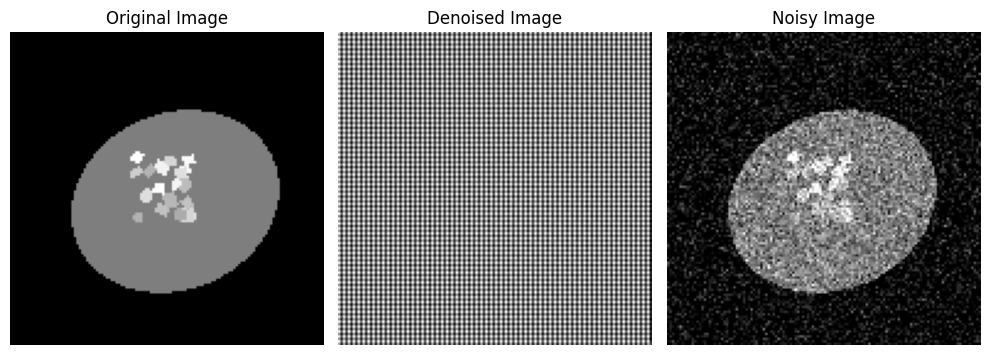

In [25]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=50,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=100, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=True,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space

# from darts.space import SearchSpace as Space
# model_space = Space()

model_space = SimpleAutoencoderSpace()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

# one-shot space

In [12]:

import nni.retiarii.nn.pytorch as nn
import torch
import logging

from nni.retiarii import model_wrapper

from collections import OrderedDict


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Convolutions(nn.Module):
    def __init__(self, conv, layer_name):
        super().__init__()

        self.conv = nn.LayerChoice(conv, label=f'{layer_name} - Step 2: Convolutions, Batchnorm and Activation')

    def forward(self, x):
        x = self.conv(x)
        return x
    
class BaseBlock(nn.Module):
    def __init__(self):
        super(BaseBlock, self).__init__()

    def get_conv_ordered_dict(self, in_channels, out_channels, ks, pd, dl, activation):
        layers = [
            ("Conv2d", nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=ks, padding=pd, dilation=dl),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.Conv2d(out_channels, out_channels, kernel_size=ks, padding=pd, dilation=dl),
                nn.BatchNorm2d(out_channels),
                activation
                )
            ),
            ("DepthwiseSeparable", nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=ks, padding=pd, dilation=dl, groups=in_channels),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                activation,
                nn.Conv2d(out_channels, out_channels, kernel_size=ks, padding=pd, dilation=dl, groups=out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                activation
                )
            )
        ]
        return OrderedDict(layers)

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class EncoderBlock(BaseBlock):
    def __init__(self, in_channels, out_channels, ks, pd, dl, activations, downsamples, layer_name):
        super(EncoderBlock, self).__init__()
        
        self.downsample = downsamples
        self.conv_layer = Convolutions(self.get_conv_ordered_dict(in_channels, out_channels, ks, pd, dl, activations), layer_name)

    def forward(self, x):
        x = self.downsample(x)
        x = self.conv_layer(x)
        return x

class DecoderBlock(BaseBlock):
    def __init__(self, in_channels, out_channels, ks, pd, dl, activations, upsamples, layer_name):
        super(DecoderBlock, self).__init__()

        self.upsample = upsamples
        self.conv_layer = Convolutions(self.get_conv_ordered_dict(in_channels, out_channels, ks, pd, dl, activations), layer_name)

    def forward(self, x, skip):
        upsampled = self.upsample(x)
        cropped = self.crop_tensor(upsampled, skip)
        return self.conv_layer(torch.cat([cropped, upsampled], 1))

@model_wrapper
class SearchSpace(BaseBlock):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        ks = 5
        dl = 3
        pd = (ks - 1) * dl // 2

        activation = nn.SiLU(inplace=True)

        self.downsamples = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upsamples = nn.Upsample(scale_factor=2,mode='nearest')

        # Conv layer in"
        self.mid_channels = 64
        self.first = nn.Sequential(
                nn.Conv2d(in_channels, self.mid_channels, kernel_size=ks, padding=pd, dilation=dl),
                nn.BatchNorm2d(self.mid_channels),
                activation,
                nn.Conv2d(self.mid_channels, self.mid_channels, kernel_size=ks, padding=pd, dilation=dl),
                nn.BatchNorm2d(self.mid_channels),
                activation
                )

        # Conv layer out
        self.out = nn.Conv2d(self.mid_channels, out_channels, kernel_size=1, padding=0, dilation=1)
        
    def forward(self, x):
        x = self.first(x)

        x = self.out(x)
        return x

In [13]:

# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=5000,
                lr=0.00005, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            callbacks=[early_stop_callback],
            max_epochs=100, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=True,
            gpus=1
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=50), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = SearchSpace()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:364: LightningDeprecationWarning: `_EarlyStopping.on_load_checkpoint` will change its signature and behavior in v1.8. If you wish to load the state of the callback, use `load_state_dict` instead. In v1.

ValueError: No architecture parameters found. Nothing to search.

In [17]:

import nni.retiarii.nn.pytorch as nn
import torch.nn.functional as F
# from nni.nas.pytorch import darts
from nni.retiarii.strategy import DARTS as darts

class _MixedOp(nn.Module):
    def __init__(self, C, stride):
        super().__init__()
        self.ops = nn.ModuleList()
        for primitive in darts.PRIMITIVES:
            op = darts.OPS[primitive](C, stride, False)
            if 'pool' in primitive:
                op = nn.Sequential(op, nn.BatchNorm2d(C, affine=False))
            self.ops.append(op)

    def forward(self, x, weights):
        return sum(w * op(x) for w, op in zip(weights, self.ops))

class CustomCell(nn.Module):
    def __init__(self, C_prev_prev, C_prev, C, reduction_prev, reduction):
        super().__init__()

        if reduction_prev:
            self.preprocess0 = darts.FactorizedReduce(C_prev_prev, C)
        else:
            self.preprocess0 = darts.ReLUConvBN(C_prev_prev, C, 1, 1, 0)
        self.preprocess1 = darts.ReLUConvBN(C_prev, C, 1, 1, 0)
        self._ops = nn.ModuleList()
        self._bns = nn.ModuleList()
        for i in range(darts.STEPS):
            for j in range(2 + i):
                stride = 2 if reduction and j < 2 else 1
                op = _MixedOp(C, stride)
                self._ops.append(op)

    def forward(self, s0, s1, weights):
        s0 = self.preprocess0(s0)
        s1 = self.preprocess1(s1)

        states = [s0, s1]
        offset = 0
        for i in range(darts.STEPS):
            s = sum(self._ops[offset + j](h, weights[offset + j]) for j, h in enumerate(states))
            offset += len(states)
            states.append(s)

        return torch.cat(states[-darts.MULTIPLICITY:], dim=1)

class DARTS_UNet(nn.Module):
    def __init__(self, C, num_classes, layers, criterion, steps=darts.STEPS, multiplier=darts.MULTIPLICITY):
        super().__init__()
        self._C = C
        self._num_classes = num_classes
        self._layers = layers
        self._criterion = criterion
        self._steps = steps
        self._multiplier = multiplier

        # For simplicity, we are going to use only two cells: a down-sampling and an up-sampling.
        self.down_cell = CustomCell(C, C, C, False, True)
        self.up_cell = CustomCell(C, C, C, False, False)

        self.cells = nn.ModuleList()
        for i in range(layers):
            if i % 2 == 0:
                self.cells.append(self.down_cell)
            else:
                self.cells.append(self.up_cell)

        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(C, num_classes)

    def forward(self, input):
        s0 = s1 = input
        for cell in self.cells:
            s0, s1 = s1, cell(s0, s1, self._arch_parameters())
        out = self.global_pooling(s1)
        logits = self.classifier(out.view(out.size(0), -1))
        return logits

    def _arch_parameters(self):
        return self._arch_parameters

    def arch_parameters(self):
        return self._arch_parameters

    def genotype(self):
        # To extract the architecture, one would typically get the top-k operations for each mixed op.
        pass

AttributeError: type object 'DARTS' has no attribute 'STEPS'